In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
%load_ext autoreload
%autoreload 2

---
## Read Data

In [2]:
from Data_prep import leave_last_out

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '../'

In [4]:
# data_path = 'Data/Amazon/'
# file_name = 'am_40k_users'

data_path = 'Data/ML/'
file_name = 'ml_1m'

In [5]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [6]:
# CFRNN Data
train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')

# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

In [43]:
train_set_cfrnn.to_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn.to_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn.to_pickle(path + data_path + file_name + '_test_cfrnn')

In [44]:
add_to_train, val_set_mf = to_mf_set(val_set_cfrnn)
add_to_train_2, test_set_mf = to_mf_set(test_set_cfrnn)
train_set_mf = pd.concat([train_set_cfrnn, add_to_train, add_to_train_2])

In [7]:
# Eval
steps = 5
rank_at = 20

---
# BPR

In [8]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 1, #around 20 is sufficient
"sample_size": 0.5*len(train_set_mf),
"seed": 1234,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.5, # Bold driver decrease alpha
          
"reg_user": 0, #0.1, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0, #0.1, # Am_40k best: 0.1 # ML_1 best: 0
}

In [9]:
from BPR import BPR
bpr = BPR(total_users, total_items, bpr_params)

In [10]:
samples_name = file_name + '_bpr_samples'

In [ ]:
samples = bpr.create_samples(train_set_mf)

In [ ]:
samples = np.array(samples)
np.save(path + data_path + 'Samples/' + samples_name, samples)

In [12]:
%%time
bpr.train_model(sample_path = path + data_path + 'Samples/' + samples_name + '.npy', val_set=val_set_mf)

iteration: 0  loss: 0.454414  rec@10: 0.016
CPU times: user 16.2 s, sys: 1.89 s, total: 18.1 s
Wall time: 15.9 s


new results created


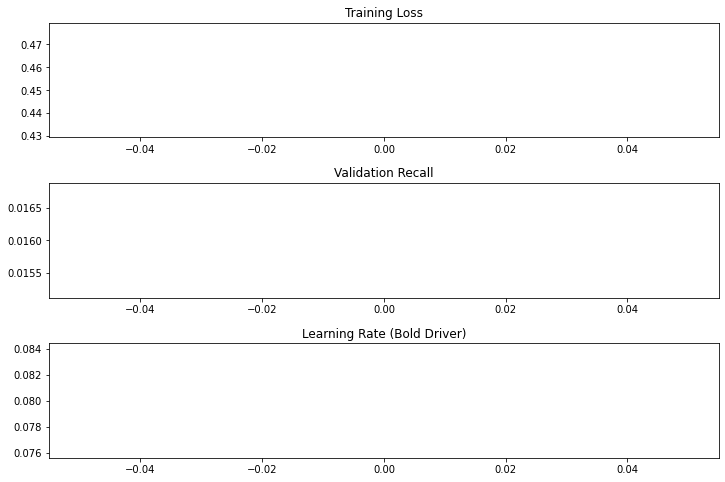

In [13]:
bpr.store_model(path + '/Logs/', file_name + '_log', file_name)
bpr.plot_training()

In [15]:
ranked_df_bpr = bpr.get_predictions(test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,1,0.001,0.00100,0.001000
1,5,9,0.009,0.00180,0.004452
2,10,20,0.020,0.00200,0.007976
3,15,33,0.033,0.00220,0.011471
4,20,39,0.039,0.00195,0.012881


In [16]:
bpr_metrics.to_pickle(path + 'Results/BPR/' + file_name + '_metrics')

---
# CFRNN

In [53]:
cfrnn_params = {
'train_time':0,
'epochs':5,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'test_users': 500,
'val_users': 500,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [54]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, cfrnn_params)
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set_cfrnn)

Creating Diveristy Bias
Compiled LSTM


In [21]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)

In [55]:
cfrnn.train(train_dataset, val_dataset, verbose=1)

Fitting LSTM with parameters:
train_time                                              0
epochs                                                  5
BATCH_SIZE                                             32
learning_rate                                         0.1
delta                                                0.01
max_seq_len                                            30
embedding_dim                                         100
rnn_units                                              20
ckpt_dir            ../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts
test_users                                            500
val_users                                             500
pad_value                                            3706
shift_targets_by                                        1
Name: 0, dtype: object
Epoch 1/5
141/141 [==============================] - 17s 118ms/step - loss: 7.7504 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
141/141 [======================

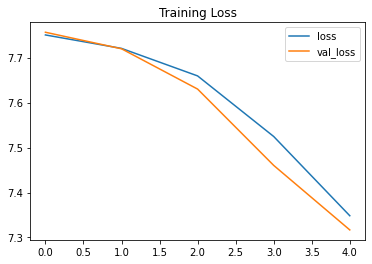

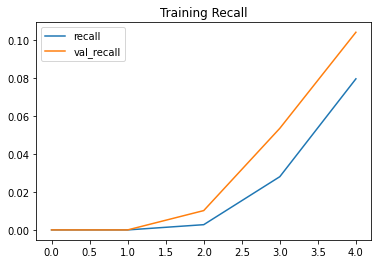

In [56]:
cfrnn.plot_training()

In [57]:
cfrnn_params['ckpt_dir']

'../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts'

In [58]:
test_set, left_out = leave_last_out(test_set_cfrnn, n_items=1)
ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out, batch_size=500, rank_at=rank_at, ckpt_dir=cfrnn_params['ckpt_dir'])
cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
cfrnn_metrics

AttributeError: 'NoneType' object has no attribute 'endswith'

In [ ]:
cfrnn_metrics.to_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

---
# NCF

In [38]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0,0],
    'epochs': 1,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/GMF_weights_{file_name}/GMF_weights',
    'optimizer':'Adam'
}

MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0,0,0,0],   #ML: [+-0.0005,0,0,0],
    'epochs': 1,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'weights_dir': f'../Logs/weights/MLP_weights_{file_name}/MLP_weights',
    'optimizer':'Adam'
}

NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0,0,0,0],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0,0],
    'nolf': 8,
    'epochs': 2,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/NeuMF_weights_{file_name}/NeuMF_weights',
    'optimizer':'Adam'
}

In [39]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)
NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

In [ ]:
sample_path = path + data_path + 'Samples/' + file_name + '_samples_4_neg/'
samples = NCF.load_samples(sample_path, file_name + '_sample', 20)

In [16]:
sample_path = '../NeuMF_storage/samples_ml_1m_cfrnn_4_neg/'
sample_name = 'ml_1m_sample_'

# sample_path = '../NeuMF_storage/samples_ml_1m_4_neg/'
# sample_name = 'ml_1m_sample_'

# sample_path = '../NeuMF_storage/samples_am_40k_4_neg/'
# sample_path = '../NeuMF_storage/samples_am_40k_8_neg/'
# sample_name = 'am_40k_sample_'

# sample_path = '../NeuMF_storage/samples_am_like_ml_4_neg/'
# sample_name = 'am_40k_sample_'

In [41]:
GMF_val_metrics = NCF.train_model('GMF', samples, val_set=val_set_mf)


Fitting GMF with parameters:
learning_rate                                           0.0005
batch_size                                                 256
nolf                                                         8
regs                                                    [0, 0]
epochs                                                       1
sample_size                                             998709
num_neg                                                      4
weights_dir      ../Logs/weights/GMF_weights_ml_1m/GMF_weights
optimizer                                                 Adam
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 37s 7us/sample - loss: 0.3812


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          7   0.014   0.002800  0.008107
2       10          7   0.014   0.001400  0.008107
3       15         10   0.020   0.001333  0.009722
4       20         15   0.030   0.001500  0.012053]


In [42]:
MLP_val_metrics = NCF.train_model('MLP', samples, val_set_mf)


Fitting MLP with parameters:
learning_rate                                           0.0005
batch_size                                                 256
layers                                         [16, 32, 16, 8]
reg_layers                                        [0, 0, 0, 0]
epochs                                                       1
sample_size                                             998709
num_neg                                                     10
weights_dir      ../Logs/weights/MLP_weights_ml_1m/MLP_weights
optimizer                                                 Adam
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 45s 9us/sample - loss: 0.3636


In [46]:
NCF.use_pretrain_model()
NCF.NeuMF_params['optimizer'] = 'SGD'

In [47]:
NeuMF_val_metrics = NCF.train_model('NeuMF', samples, val_set=val_set_mf)


Fitting NeuMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                                            [0, 0, 0, 0]
reg_mf                                                      [0, 0]
nolf                                                             8
epochs                                                           2
sample_size                                                 998709
num_neg                                                          4
weights_dir      ../Logs/weights/NeuMF_weights_ml_1m/NeuMF_weights
optimizer                                                      SGD
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 51s 10us/sample - loss: 0.3264
Epoch: 1
Train on 4993545 samples
4993545/4993545 [==============================] - 50s 10u

In [49]:
ranked_df_neumf = NCF.get_predictions('NeuMF', test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,3,0.003,0.00300,0.003000
1,5,13,0.013,0.00260,0.007984
2,10,31,0.031,0.00310,0.013801
3,15,45,0.045,0.00300,0.017524
4,20,59,0.059,0.00295,0.020816


In [50]:
neumf_metrics.to_pickle(path + 'Results/NCF/' + file_name + '_metrics')

---
## Compare

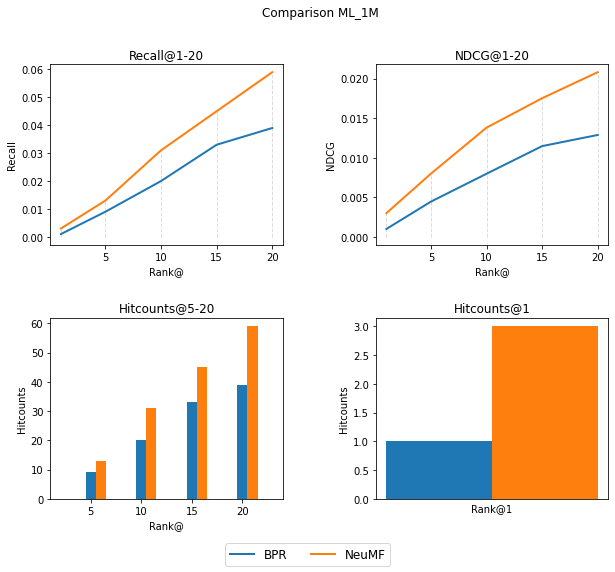

In [52]:
from visualize_results import plot_metrics
plot_metrics([bpr_metrics, neumf_metrics], 'Comparison ML_1M', ['BPR', 'NeuMF'])